# Lab Work 5 (Student version): label propagation algorithm

We can use the following libraries.

In [62]:
import matplotlib.pyplot as plt
import math
import sys
import random
import time
import numpy as np
from collections import defaultdict #1
print(sys.version)

3.9.6 (default, Sep 19 2022, 09:09:38) 
[GCC 10.2.1 20210110]


In [56]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

### Question 1

We remind here the Label Propagation algorithm described in the course:

* 1. initialization: give a unique label to each node in the network

* 2. Arrange the nodes in the network in a random order

* 3. For each node in the network in this random order set its label to the majority label among its neighbours (in case of ties, decide randomly)

* 4. Go back to step 2 and iterate until all nodes have a label corresponding to the highest frequency in their neiborhood.

Implement this algorithm, the output is a table with the community of each node.

Apply it to the CAIDA dataset on Moodle.

In [70]:
def init_assignment(node_ids, community_assignment):
    for node_id in node_ids:
        community_assignment[node_id] = node_id

In [71]:
def get_frequencies_labels(neighbours, community_assignment):
    frequencies_labels = {}
    for neighbour in neighbours:
        neighbour_label = community_assignment[neighbour]
        if neighbour_label not in frequencies_labels:
            frequencies_labels[neighbour_label] = 0
        frequencies_labels[neighbour_label] += 1
    return frequencies_labels

In [72]:
def convert_to_adjacency(adjacency_matrix, size):
    col, row = adjacency_matrix.nonzero()
    my_graph = {}
    for i in range(size):
        my_graph[i] = []
    for i in range(len(col)):
        my_graph[col[i]].append(row[i])
    return my_graph

In [73]:
def label_propagation(adjacency_list):
    community_assignment = {}
    node_ids = list(adjacency_list.keys())  # Get node IDs from the adjacency list
    init_assignment(node_ids, community_assignment)  # step 1
    end = False
    while not end:
        random.shuffle(node_ids)  # step 2
        for node_id in node_ids:  # step 3
            neighbours = adjacency_list[node_id]
            frequencies_labels = get_frequencies_labels(neighbours, community_assignment)
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                community_assignment[node_id] = max_frequency_label

        for node_id in node_ids:
            node_label = community_assignment[node_id]
            neighbours = adjacency_list[node_id]
            frequencies_labels = get_frequencies_labels(neighbours, community_assignment)
            if len(frequencies_labels) > 0:
                max_frequency_label = max(frequencies_labels, key=frequencies_labels.get)
                if node_label != max_frequency_label:
                    end = False
                    break
                else:
                    end = True

    return community_assignment

In [74]:
filename = "as_caida.txt"
graph = load_graph(filename)

In [115]:
community_assignment = label_propagation(graph)

In [116]:
community_assignment

{'1': '2',
 '2': '2',
 '3': '2',
 '4': '4',
 '30': '30',
 '43': '43',
 '82': '82',
 '90': '90',
 '95': '95',
 '292': '292',
 '618': '2',
 '642': '642',
 '699': '2',
 '706': '706',
 '712': '18',
 '762': '2',
 '951': '951',
 '964': '2',
 '991': '991',
 '1053': '1053',
 '1067': '2',
 '1124': '2',
 '1188': '2',
 '1502': '1502',
 '1503': '2',
 '1682': '2',
 '2015': '2015',
 '2020': '2015',
 '2310': '2',
 '2501': '95',
 '2529': '2',
 '2770': '2',
 '3084': '18',
 '3158': '2',
 '3423': '2',
 '3456': '2',
 '3489': '2',
 '3542': '2',
 '3593': '18',
 '3636': '792',
 '3658': '2',
 '3683': '3683',
 '3684': '2',
 '3706': '2',
 '3712': '2',
 '3729': '2',
 '3921': '3921',
 '3928': '2',
 '4114': '2',
 '4155': '2',
 '4156': '2',
 '4318': '2',
 '4319': '2',
 '4479': '2',
 '4482': '2',
 '4622': '2',
 '4742': '2',
 '5015': '2',
 '5059': '2',
 '5368': '2',
 '6165': '2',
 '6232': '6232',
 '6235': '2',
 '6295': '2',
 '6314': '2',
 '6422': '2',
 '6498': '2',
 '8740': '2',
 '8751': '2',
 '8819': '2',
 '8844': '

### Question 2

Compute and plot the distribution of the community sizes that you obtained.

Comment the distribution: its shape and what it reveals about the communities detected by the LP algorithm.

In [67]:
community_sizes = defaultdict(int)

for node, community in community_assignment.items():
    community_sizes[community] += 1

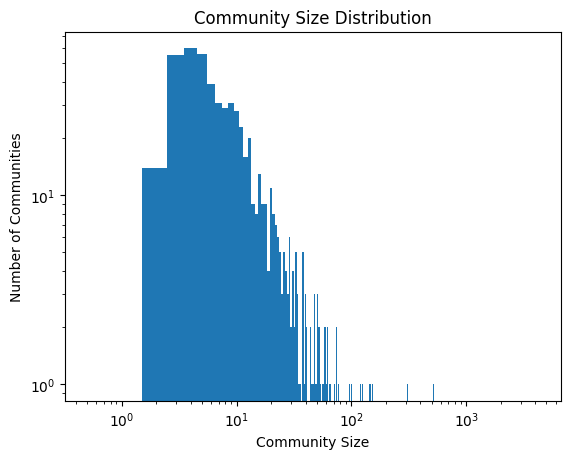

In [65]:
# Get the counts of community sizes
size_counts = list(community_sizes.values())

# Create a histogram of community sizes
plt.hist(size_counts, bins=range(1, max(size_counts) + 2), align='left')

plt.xscale("log")
plt.yscale("log")

# Set labels and title
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Community Size Distribution')

# Show the plot
plt.show()

### Question 3

We remind you of the definition of the modularity score:

$$ Q = \frac{1}{2m} \sum_{i = 1}^{k}  \sum_{u \in S_i} d(u)_{in} -  \frac{vol(S_i)^2}{ 2m } $$

where 

* $d(u)_{in}$ is the part if the degree of node $u$ that goes to nodes in $ S_i $

* $vol(S_i) = \sum_{u \in S_i} d(u)$ is the sum of the degree of a node inside a community

Compute the modularity of the result of LP algorithm on Erdös-Rényi graphs of various densities to check if the results seem consistent.

In [106]:
def erdos_renyi_graph(node_count, link_count):
    graph = {}
    
    for node_index in range(node_count):
        graph[node_index] = []
        
    while link_count > 0:
        node1, node2 = random.randint(0, node_count - 1), random.randint(0, node_count - 1)
        if node1 != node2 and node1 not in graph[node2]:
            graph[node1].append(node2)
            graph[node2].append(node1)
            link_count -= 1
    
    return graph

In [107]:
node_count = 26475
link_count = 53381
er_caida_graph = erdos_renyi_graph(node_count,link_count)

In [103]:
def calculate_modularity(adjacency_matrix, community_assignment):
    # Step 1: Calculate the degree of each node
    degrees = [sum(adjacency_matrix[i]) for i in range(len(adjacency_matrix))]
    
    # Step 2: Compute the modularity score
    num_nodes = len(adjacency_matrix)
    num_communities = len(set(community_assignment.values()))
    modularity = 0
    m = sum(degrees) / 2  # Total edge weight divided by 2

    for community in set(community_assignment.values()):
        nodes_in_community = [node for node, comm in community_assignment.items() if comm == community]
        vol = sum(degrees[node] for node in nodes_in_community)
        in_degree = sum(adjacency_matrix[i][j] for i in nodes_in_community for j in nodes_in_community)
        modularity += (in_degree / (2 * m)) - ((vol / (2 * m)) ** 2)
    
    return modularity

In [109]:
def adjacency_list_to_adjacency_matrix(adjacency_list):
    # Find the number of nodes
    num_nodes = len(adjacency_list)
    
    # Initialize an empty adjacency matrix filled with zeros
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    
    # Fill in the matrix based on the adjacency list
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            adjacency_matrix[node, neighbor] = 1
    
    return adjacency_matrix

In [110]:
adjacency_matrix = adjacency_list_to_adjacency_matrix(er_caida_graph)

In [113]:
modularity_score = calculate_modularity(adjacency_matrix, community_assignment)
print(f"Modularity Score: {modularity_score}")

TypeError: list indices must be integers or slices, not str

### Question 4

Compute the modularity of the partition that you obtained.

Make several other realizations of the LP algorithm on CAIDA and comment the results and range of values.

### Question 5

Run the LP algorithm on the various undirected graphs that you have (for instance INET, Amazon), compute the modularity and comment. 